<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/5_1_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация CatBoostClassifier с использованием GPU (CUDA 12.5) для классификации узлов на датасете Bitcoin-OTC

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

Небходимо выбрать среду выполнения с GPU: Среда выполнения → Сменить среду выполнения → Графический процессор T4


## 1. Установка зависимостей

Требования:
- CatBoost ≥1.2.2
- PyTorch Geometric для загрузки данных

* CatBoost автоматически использует доступные GPU через CUDA, явная установка CUDA 12.5 не требуется

In [1]:
install = True
if install:
  !pip install -q torch torchvision torchaudio
  !pip install -q torch-geometric
  !pip install -q catboost
  !pip install -q networkx
  !pip install -q matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99

## 2. Импорт библиотек

In [2]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import BitcoinOTC
from torch_geometric.utils import to_networkx
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report

## 3. Загрузка данных

In [3]:
dataset = BitcoinOTC(root='/tmp/BTC')
data = dataset[0]

Extracting /tmp/BTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


## 4. Создание признаков узлов и ребер

### 4.1. Признаки узлов

In [4]:
# Создание синтетических признаков узлов
G = to_networkx(data, to_undirected=True)
degrees = dict(G.degree())
pagerank = nx.pagerank(G)
clustering = nx.clustering(G)

# Метрики узлов как признаки (3 признака)
node_degrees = np.array([degrees[i] for i in range(data.num_nodes)]).reshape(-1, 1)
node_pagerank = np.array([pagerank[i] for i in range(data.num_nodes)]).reshape(-1, 1)
node_clustering = np.array([clustering[i] for i in range(data.num_nodes)]).reshape(-1, 1)

# Комбинирование признаков в тензор
X_tensor = torch.tensor(np.hstack([
    node_degrees,
    node_pagerank,
    node_clustering
]), dtype=torch.float32)

### 4.2. Признаки соседей

In [5]:
# Агрегация признаков соседей (на основе реальных признаков)
def aggregate_features(edge_index, features, aggregator='mean'):
    """Агрегация признаков соседей с обработкой узлов без соседей"""
    num_nodes = features.shape[0]
    feat_dim = features.shape[1]
    aggregated = torch.zeros((num_nodes, feat_dim))

    for i in range(num_nodes):
        # Получаем индексы исходящих ребер для узла i
        mask = edge_index[0] == i
        if not mask.any():
            # Нет исходящих ребер — оставляем нули
            continue

        neighbors = edge_index[1][mask]

        if aggregator == 'mean':
            aggregated[i] = features[neighbors].mean(dim=0)
        elif aggregator == 'max':
            if len(neighbors) == 0:
                aggregated[i] = torch.zeros(feat_dim)
            else:
                aggregated[i], _ = features[neighbors].max(dim=0)
        elif aggregator == 'sum':
            aggregated[i] = features[neighbors].sum(dim=0)

    return aggregated.numpy()

# Преобразование edge_index в numpy для поиска соседей
edge_index_np = data.edge_index.numpy()

# Агрегация по соседям (3 типа агрегации)
agg_mean = aggregate_features(edge_index_np, X_tensor, 'mean')
agg_max = aggregate_features(edge_index_np, X_tensor, 'max')
agg_sum = aggregate_features(edge_index_np, X_tensor, 'sum')

### 4.3. Финальная матрица признаков

In [6]:
# Финальная матрица признаков (3 + 3 + 3 + 3 = 12 признаков)
X = np.hstack([
    node_degrees,
    node_pagerank,
    node_clustering,
    agg_mean,
    agg_max,
    agg_sum
])

# Проверка формы признаков
print(f"Форма X: {X.shape}")  # Должно быть (num_nodes, 12)

Форма X: (6005, 12)


## 5. Создание меток классов (гарантированно 3 класса)

In [7]:
degree_centrality = np.array([degrees[i] for i in range(data.num_nodes)])
min_class_size = 5
sorted_indices = np.argsort(degree_centrality)
num_nodes = len(sorted_indices)
class_size = num_nodes // 3

labels = np.zeros(num_nodes, dtype=int)
for i in range(3):
    start_idx = i * class_size
    end_idx = (i+1)*class_size if i < 2 else num_nodes
    labels[sorted_indices[start_idx:end_idx]] = i

## 6. Стратифицированное разделение данных

In [8]:
def stratified_split(labels, train_ratio=0.6, val_ratio=0.2, seed=12):
    np.random.seed(seed)
    unique_classes = np.unique(labels)
    train_indices, val_indices, test_indices = [], [], []

    for cls in unique_classes:
        cls_indices = np.where(labels == cls)[0]
        np.random.shuffle(cls_indices)

        train_end = int(train_ratio * len(cls_indices))
        val_end = train_end + int(val_ratio * len(cls_indices))

        train_indices.extend(cls_indices[:train_end])
        val_indices.extend(cls_indices[train_end:val_end])
        test_indices.extend(cls_indices[val_end:])

    return (
        np.array(train_indices, dtype=int),
        np.array(val_indices, dtype=int),
        np.array(test_indices, dtype=int)
    )

train_idx, val_idx, test_idx = stratified_split(labels)

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = labels[train_idx], labels[val_idx], labels[test_idx]

## 7. Модель

In [9]:
# Расчет весов классов
class_counts = np.bincount(y_train)
min_weight = 1e-2
class_weights = {
    i: max(1.0 / (count + 1e-5), min_weight)
    for i, count in enumerate(class_counts)
}

# Создание CatBoost модели с GPU
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    class_weights=class_weights,
    early_stopping_rounds=50,
    verbose=100,
    random_seed=42
)

# Обучение модели
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 0.1776358	test: 0.1684334	best: 0.1684334 (0)	total: 17.6ms	remaining: 17.6s
bestTest = 0.1684334089
bestIteration = 0
Shrink model to first 1 iterations.


## 8. Оценка

In [10]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       401
           1       0.33      1.00      0.50       401
           2       1.00      0.00      0.01       402

    accuracy                           0.33      1204
   macro avg       0.44      0.33      0.17      1204
weighted avg       0.44      0.33      0.17      1204



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 9. Важность признаков

Число признаков: 12


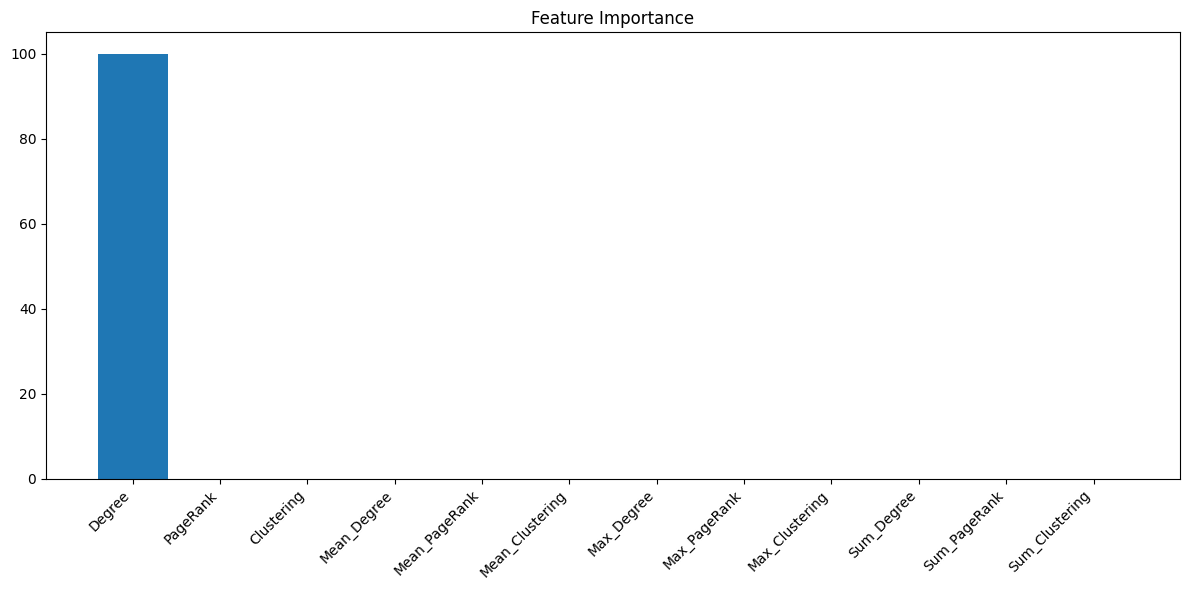

In [11]:
# Feature Importance
feature_importance = model.get_feature_importance()
print(f"Число признаков: {len(feature_importance)}")  # Должно быть 12

# Визуализация важности признаков
feature_names = [
    'Degree', 'PageRank', 'Clustering',
    'Mean_Degree', 'Mean_PageRank', 'Mean_Clustering',
    'Max_Degree', 'Max_PageRank', 'Max_Clustering',
    'Sum_Degree', 'Sum_PageRank', 'Sum_Clustering'
]

plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importance)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## 10. Сохранение модели

In [12]:
model.save_model('catboost_model.cbm')
print("Модель сохранена в 'catboost_model.cbm'")

Модель сохранена в 'catboost_model.cbm'


## 11. Загрузка модели

In [13]:
loaded_model = CatBoostClassifier()
loaded_model.load_model('catboost_model.cbm')
print("Модель загружена из 'catboost_model.cbm'")

Модель загружена из 'catboost_model.cbm'


In [14]:
# Проверка загруженной модели
val_pred = loaded_model.predict(X_val)
test_pred = loaded_model.predict(X_test)

val_f1 = f1_score(y_val, val_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print(f'\nValidation Weighted F1: {val_f1:.4f}')
print(f'Test Weighted F1: {test_f1:.4f}')


Validation Weighted F1: 0.1684
Test Weighted F1: 0.1699
